# Libraries and Data

In [1]:
from time import time
from random import random
from geopy.distance import distance

# Markov Decision Process Environment

## Agent

In [2]:
class Agent:
    def __init__(self, name, age, qualifications, location, region, gender, languages, race, availabilities):
        self.name = name
        self.age = age
        self.qualifications = qualifications # nurse, cpr, massage, physio and/or revalidation
        self.location = location # (lat, lon)
        self.region = region # A, B, C...
        self.gender = gender # male or female
        self.languages = languages # spanish, catalan, french and/or english
        self.race = race # white, latin-american, black or asian
        self.availabilities = availabilities # see time slot explanation below
        self.current_availabilities = self.availabilities.copy() # a copy of availabilities that can change when an agent gets assigned to a service
        self.active = True # agents can randomly (de)activate at given times
        self.worked_hours = 0
        self.assigned_hours = 0
        self.total_overtime = 0
        self.normal_hours = 8
    
    def is_available(self, time_slot):
        return all(slot in self.current_availabilities for slot in time_slot)
    
    def assign(self, time_slot):
        if (self.is_available(time_slot)):
            l = [slot for slot in self.current_availabilities if slot not in time_slot] # remove all elements of time_slot from current availabilities
            self.current_availabilities = l
            self.assigned_hours += len(time_slot)
        else:
            raise Exception
    
    def work(self):
        self.worked_hours += self.assigned_hours
    
    def reset_availabilities(self):
        self.current_availabilities = self.availabilities.copy()
    
    def to_string(self):
        return "Agent " + self.name

An agent represents a caregiver as a set of defining features.

<b>ASSUMPTION:</b> a day is represented as 48 intervals 30 mins. A time slot is then defined as a list of 30 min intervals. So slot 1 refers to the interval [00:00 - 00:30], slot 2 refers to [00:30 - 01:00], etc.

Thus for example the list [15, 16, 17, ..., 30] is an abstracted way to represent that an agent is available from slot 15 ([07:00 - 07:30]) until slot 30 ([14:30 - 15:00]). So the agent is available from 07:00 until 15:00. 

A complete list of representations can be found below:

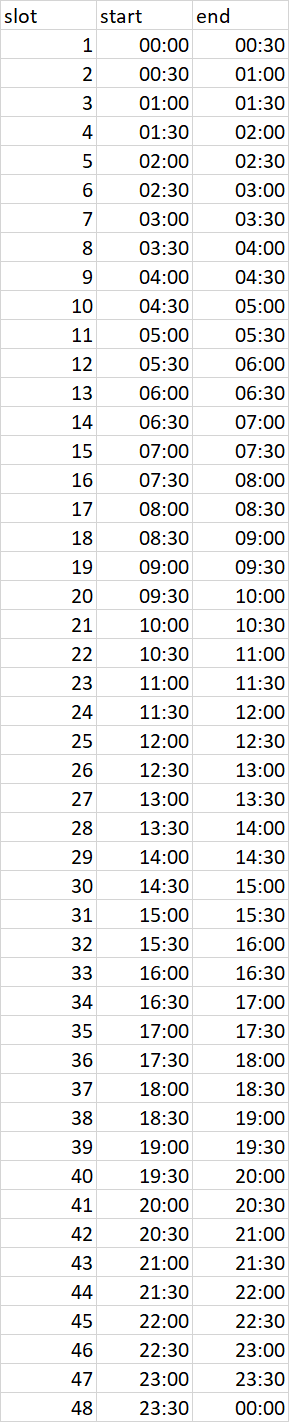

In [3]:
# Create sample agents

agent1 = Agent('Test Agent 1', age = 43, qualifications = ['nurse', 'cpr', 'physio'], location = (41.3, 2.625), region = 'A', 
               gender = 'M', languages = ['spanish'], race = 'white',
               availabilities = list(range(18, 24)) + list(range(25, 37)))

agent2 = Agent('Test Agent 2', age = 22, qualifications = [], location = (45.967, 2.004), region = 'C', 
               gender = 'F', languages = ['spanish', 'catalan'], race = 'latin-american',
               availabilities = list(range(15, 24)) + list(range(25, 30)))

agent3 = Agent('Test Agent 3', age = 61, qualifications = ['cpr', 'massage', 'nurse'], location = (42.768, 1.87), region = 'A', 
               gender = 'F', languages = ['catalan'], race = 'latin-american',
               availabilities = list(range(12, 28)))

agent4 = Agent('Test Agent 4', age = 34, qualifications = ['cpr', 'massage', 'physio'], location = (42.7, 1.97), region = 'B', 
               gender = 'F', languages = ['catalan'], race = 'latin-american',
               availabilities = list(range(18, 24)) + list(range(25, 37)))

agent5 = Agent('Test Agent 5', age = 42, qualifications = [], location = (39.78, 2.908), region = 'A', 
               gender = 'F', languages = ['catalan'], race = 'asian',
               availabilities = list(range(18, 24)) + list(range(25, 37)))

agent6 = Agent('Test Agent 6', age = 37, qualifications = ['nurse', 'physio', 'massage'], location = (40.7, 2.14), region = 'A', 
               gender = 'F', languages = ['catalan'], race = 'white',
               availabilities = list(range(12, 28)))

agent7 = Agent('Test Agent 7', age = 57, qualifications = ['physio', 'revalidation', 'nurse'], location = (41.23, 2.09), region = 'A', 
               gender = 'F', languages = ['catalan'], race = 'white',
               availabilities = list(range(29, 49)))

all_agents = [agent1, agent2, agent3, agent4, agent5, agent6, agent7]

## Service

In [4]:
class Service: 
    def __init__(self, name, age, service_type, location, region, gender, languages, race, time_slot):
        self.name = name
        self.age = age
        self.service_type = service_type # nurse, cpr, massage, physio and/or revalidation
        self.location = location # (lat, lon)
        self.region = region # A, B, C...
        self.gender = gender # male or female
        self.languages = languages # spanish, catalan, french and/or english
        self.race = race # white, latin-american, black or asian
        self.time_slot = time_slot # time slot in which service is needed
        self.active = True # services can randomly (de)activate at given times
    
    def to_string(self):
        return "Service " + self.name

A service represents an elderly as a set of defining features.

In [5]:
# Create sample services

service1 = Service(name = 'Test Service 1', age = 73, service_type = [], location = (46.3, 2.6), region = 'C', 
               gender = 'F', languages = ['spanish'], race = 'white',
               time_slot = list(range(14, 17)))

service2 = Service(name = 'Test Service 2', age = 82, service_type = ['cpr', 'massage'], location = (43.547, 1.765), region = 'A', 
               gender = 'M', languages = ['catalan'], race = 'latin-american',
               time_slot = list(range(26, 32)))

service3 = Service(name = 'Test Service 3', age = 86, service_type = ['nurse'], location = (41.7, 2.763), region = 'C', 
               gender = 'F', languages = ['spanish', 'catalan'], race = 'white',
               time_slot = list(range(30, 35)))

all_services = [service1, service2, service3]

## Pair

In [6]:
# TODO: is agent transportation cost included in hourly rate or covered by firm?
class Pair:
    def __init__(self, agent, service):
        self.agent = agent
        self.service = service
        
        # time_periods are the 'overlap' time interval(s) in which both the agent is available and the service is need
        self.time_periods = [slot for slot in agent.current_availabilities if slot in service.time_slot]
        
    def isLegal(self):
        # 3 conditions: times must match, agent must have correct qualifications and both agent and service need to be active
        if self.agent.active == False or self.service.active == False:
            return False
        
        if(len(self.time_periods) != len(self.service.time_slot)):
            return False # if there are no time periods, the pair is not possible
        
        for s_type in self.service.service_type: # agent needs to be qualified to perform the service
            if(s_type not in self.agent.qualifications):
                return False
        
        return True
    
    # TODO: check scoring function: very important & based on arbitrary scaling
    def similarity_score(self):
        sim = 0
        # score that reflects how similar a service and an agent are. A higher similarity score obviously means a more 'desirable pairing'
        if self.agent.age < (self.service.age - 35):
            sim -= 3
        elif self.agent.age > (self.service.age - 20):
            sim += 6
        
        if self.agent.region == self.service.region:
            sim += 10
        else:
            sim -= 10
        
        if self.agent.gender == self.service.gender:
            sim += 10
        else:
            sim -= 10
        
        num_common_lang = len(set(self.service.languages) & set(self.agent.languages))
        if num_common_lang == 0:
            sim -= 50
        elif num_common_lang > 1:
            sim += 5
        
        if self.agent.race == self.service.race:
            sim += 5
        else:
            sim -= 5
            
        dist = distance(self.agent.location, self.service.location).km
        sim -= dist * 0.10
        
        return sim
    
    def to_string(self):
        return "Pair of " + self.agent.name + " and " + self.service.name

A pair represents a match of an agent to a service.

In [8]:
# Create sample pairs

pair1 = Pair(agent = agent1, service = service1)
pair2 = Pair(agent = agent1, service = service3)
pair3 = Pair(agent = agent2, service = service2)

In [9]:
# builds all possible legal pairs: 

def build_all_legal_pairs():
    pairs = list()
    for agent in all_agents:
        for service in all_services:
            pair = Pair(agent = agent, service = service)
            if pair.isLegal():
                pairs.append(pair)
    return pairs

## State

In [10]:
class State:
    def __init__(self, pairs):
        self.pairs = pairs
        self.services, self.agents = list(), list()
        for pair in self.pairs:
            self.services.append(pair.service)
            self.agents.append(pair.agent)
    
    def isLegal(self):
        # all pairs must be legal
        for pair in self.pairs:
            if pair.isLegal() == False:
                return False
            
        # all services must be fulfilled
        if len(all_services) != len(self.services):
            return False
        for service in all_services:
            if service not in self.services:
                return False
        return True
    
    def similarity_score(self):
        sim = 0
        for pair in self.pairs:
            sim += pair.similarity_score()
        return sim
    
    def consistency_score(self, previous_state):
        sim = 0
        for pair in self.pairs:
            if pair in previous_state.pairs:
                sim += 1
        sim = sim / len(self.pairs)
        return sim
    
    def to_string(self):
        s=""
        for pair in self.pairs:
            s += pair.to_string()
            s += "; "
        return s[0:len(s)-1]

A state represents a combination of legal agent-service pairs where all services are fulfilled.

In [11]:
def build_matches():
    # key: services
    # value: list of which eligible agents for this service
    
    all_legal_pairs = build_all_legal_pairs()
    matches = dict()
    
    for service in all_services:
        match = list()
        for pair in all_legal_pairs:
            if pair.service == service:
                match.append(pair.agent)
        matches[service] =  match
        
    return matches

Matches reflect a summary of all possible eligible agents for every given service.

In [12]:
def reset_agents():
    for agent in all_agents:
        agent.assigned_hours = 0
        agent.reset_availabilities()

In [13]:
def build_state_space():
    reset_agents()
    matches = build_matches()
    n=0 # safety to avoid endless while loop

    pointers = dict()
    for service in matches.keys():
        pointers[service] = 0 

    state_space = list()
    done = False
    while(done == False and n < 100000):
        n+=1
        pairs = list()
        considered_agents, considered_time_slots = list(), list()
        
        for service in matches.keys():
            service_pointer = pointers[service]
            considered_agent = matches[service][service_pointer]
            potential_pair = Pair(agent = considered_agent, service = service)
            
            if potential_pair.isLegal(): # success
                pairs.append(potential_pair)
                considered_agent.assign(service.time_slot)
                considered_agents.append(considered_agent)
                considered_time_slots.append(service.time_slot)
                
                if(service == list(matches)[-1]): # last service was successfully allocated: total success
                    state = State(pairs)
                    state_space.append(state)
                    idx = list(matches.keys()).index(service)
                    pointers, done = update_pointers(idx, service, pointers, matches)

                    if done:
                        break

            else: # failure
                idx = list(matches.keys()).index(service)
                pointers, done = update_pointers(idx, service, pointers, matches)
                rollback_slots(agents=considered_agents, time_slots=considered_time_slots)
                break
                
    return state_space

def update_pointers(idx, service, pointers, matches): # updates pointer of service
    if pointers[service] == (len(matches[service])-1): # pointer points to last eligible agent for service
        if idx == 0: # there are no more routes to consider
            return None, True
        else:
            pointers[service] = 0
            s = list(matches.keys())[idx-1]
            return update_pointers(idx-1, s, pointers, matches)
    
    else: # still eligible agents left for this service
        pointers[service] += 1
        return pointers, False

def rollback_slots(agents, time_slots):
    for idx in range(len(agents)):
        agents[idx].current_availabilities.extend(time_slots[idx])

State space represents all possible (legal) states.

In [14]:
start_time = time()
state_space = build_state_space()
print("--- %s seconds ---" % (time() - start_time))

## Action

In [15]:
def build_action_space():
    state_space = build_state_space()
    return state_space.copy()

In [16]:
action_space = build_action_space()

An action represents going from one state to the next.

The action space equals the state space because every state is reachable independent of the state at the previous timestep.

## Reward

In [17]:
# TODO: check pricing: very important & based on arbitrary numbers
def reward(state, previous_state, end_of_month):
    HOUR_PRICE = 5
    OVERTIME_PRICE = 7
    
    reward = 0
    reward += state.similarity_score()
    reward += state.consistency_score(previous_state)
    
    total_hours = 0
    for agent in all_agents:
        total_hours += agent.assigned_hours
        total_overtime += agent.total_overtime
        total_idle += agent.total_idle
    reward -= total_hours * HOUR_PRICE
    
    if end_of_month:
        
        net_overtime, net_idle = 0, 0
        for agent in all_agents:
            diff = agent.worked_hours - (agent.normal_hours * 30)
            if diff > 0: # agent (net) worked more than expected -> diff = net overtime
                net_overtime += diff
            else: # agent (net) worked exactly as expected or idle -> diff is net idle
                net_idle += abs(diff)    
            
        # account for cost of idle
        reward -= net_idle * HOUR_PRICE # idle agents still get payed a base 'normal' amount
        
        # account for overtime pay
        reward -= net_overtime * OVERTIME_PRICE
        
        # process end of month
        for agent in all_agents:
            agent.worked_hours = 0
        
        return reward, True
    
    return reward, False

## Environment

In [18]:
class Environment():
    def __init__(self):
        self.state_space = build_state_space()
        self.action_space = build_action_space()
        self.legal_action_space = self.action_space.copy()
        self.num_actions = 0 # keeps track of number of actions -> num_actions a multiple of 365 indicates end of year
        self.current_state = None
        self.previous_state = None
    
    def transition(self, change_prob=0.01):
        change = False
        
        for agent in all_agents:
            agent.work() # all agents will work their assigned hours (can be 0 if unassigned agent)
            if random() < change_prob: # change prob probability of happening
                agent.active = not agent.active
                change = True
        for service in all_services:
            if random() < change_prob: # change prob probability of happening
                service.active = not service.active
                change = True
        
        if change:
            self.legal_action_space = build_action_space()
    
    def perform_action(self, action):
        if action not in self.legal_action_space:
            raise Exception
        else:
            self.num_actions += 1
            self.previous_state = self.current_state
            self.current_state = action
            self.transition()
            
            for agent in all_agents:
                agent.work()
            
            if self.num_actions % 30 == 0:
                end_of_month = True
            else:
                end_of_month = False
                
            reward, done = reward(state=self.current_state, previous_state=self.previous_state, end_of_month = end_of_month)
            return reward, done

# Reinforcement Learning Algorithm

In [19]:
env = Environment()

In [20]:
# TODO create Q-table of shape (state_space, TOTAL action_space)

# Heuristic Benchmark

# Performance Comparison & Conclusion